In [11]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

In [12]:
# https://drive.google.com/file/d/1aqAvaSSc3ShXbhPmLyfVWwOsTbalKR3O/view?usp=sharing
# https://drive.google.com/file/d/1lOyENvLKFWirgQt5lSsqzUSSix5kX7Hp/view?usp=sharing
# https://drive.google.com/file/d/1qc8y8ClGksYOHcyr_QOCSeoG4LBD_Jwp/view?usp=sharing

file_id = '1aqAvaSSc3ShXbhPmLyfVWwOsTbalKR3O'
years = f"https://drive.google.com/uc?id={file_id}"

file_id = '1lOyENvLKFWirgQt5lSsqzUSSix5kX7Hp'
daily = f"https://drive.google.com/uc?id={file_id}"

file_id = '1qc8y8ClGksYOHcyr_QOCSeoG4LBD_Jwp'
mounthly = f"https://drive.google.com/uc?id={file_id}"

years = pd.read_csv(years)
daily = pd.read_csv(daily)
mounthly = pd.read_csv(mounthly)

In [13]:
# Функция для создания данных для временных рядов
def create_dataset(data, time_step=60):
    X, y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(X), np.array(y)

In [14]:
df = daily[daily['Country'].isin(['Japan'])] # выбрал только Japan

df_clean = df.dropna()

df_clean['Date'] = pd.to_datetime(df['Date'])
df2 = df_clean.select_dtypes(include=['float64', 'int64'])

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(df2)

C:\Users\palux\AppData\Local\Temp\ipykernel_22212\2974021741.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['Date'] = pd.to_datetime(df['Date'])


In [15]:
# Разделим данные на обучающие и тестовые (80% на обучение, 20% на тест)
train_size = int(len(df) * 0.8)
train_data = data_scaled[:train_size]
test_data = data_scaled[train_size:]

# Преобразуем данные в формат, пригодный для LSTM
time_step = 60  # 60 дней для предсказания
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

# Изменим форму данных для подачи в модель (samples, time_steps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(9911, 60, 1) (9911,) (1953, 60, 1) (1953,)


In [16]:
model = Sequential()

# Добавляем свёрточный слой
model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(MaxPooling1D(pool_size=2))

# Добавляем слой LSTM
model.add(LSTM(units=50, return_sequences=False))

# Добавляем выходной слой
model.add(Dense(units=1))

# Компиляция модели
model.compile(optimizer='adam', loss='mean_squared_error')

# Сводка модели
model.summary()

history = model.fit(X_train, y_train, epochs=4, batch_size=32, validation_data=(X_test, y_test))

# Прогнозирование на тестовых данных
predictions = model.predict(X_test)

# Преобразуем предсказания обратно в исходный масштаб
predictions = scaler.inverse_transform(predictions)
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

C:\Users\palux\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 58, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 29, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 50)             │        23,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,307 (91.04 KB)

 Trainable params: 23,307 (91.04 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.0098 - val_loss: 7.5853e-05
Epoch 2/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 1.2582e-04 - val_loss: 6.2194e-05
Epoch 3/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 9.7177e-05 - val_loss: 4.4025e-05
Epoch 4/4
310/310 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step - loss: 8.9804e-05 - val_loss: 3.6861e-05
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


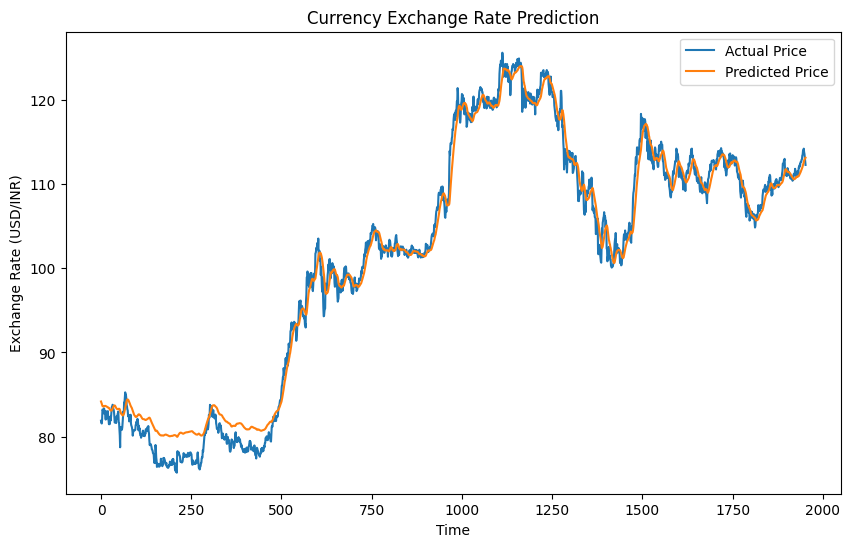

In [17]:
# Визуализируем результаты
plt.figure(figsize=(10,6))
plt.plot(y_test_actual, label='Actual Price')
plt.plot(predictions, label='Predicted Price')
plt.title('Currency Exchange Rate Prediction')
plt.xlabel('Time')
plt.ylabel('Exchange Rate (USD/INR)')
plt.legend()
plt.show()
